In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

from tensorflow.keras import backend as K
K.clear_session()


2024-10-29 23:25:07.349799: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-29 23:25:07.505056: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730224507.562461  147346 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730224507.578732  147346 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-29 23:25:07.718678: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
import tensorflow as tf

# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Optionally, list details about the available GPU devices
print(tf.config.list_physical_devices('GPU'))


Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from tensorflow.keras import mixed_precision

# Enable mixed precision
mixed_precision.set_global_policy('mixed_float16')


In [4]:
# importing necessary libraries

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "/media/ritika/BAB4DC86B4DC4713/ICDCIT/Diabetic Retinopathy/Diabetic-Retinopathy/Dataset_split/train"
test_dir = "/media/ritika/BAB4DC86B4DC4713/ICDCIT/Diabetic Retinopathy/Diabetic-Retinopathy/Dataset_split/test"
val_dir = "/media/ritika/BAB4DC86B4DC4713/ICDCIT/Diabetic Retinopathy/Diabetic-Retinopathy/Dataset_split/validation"

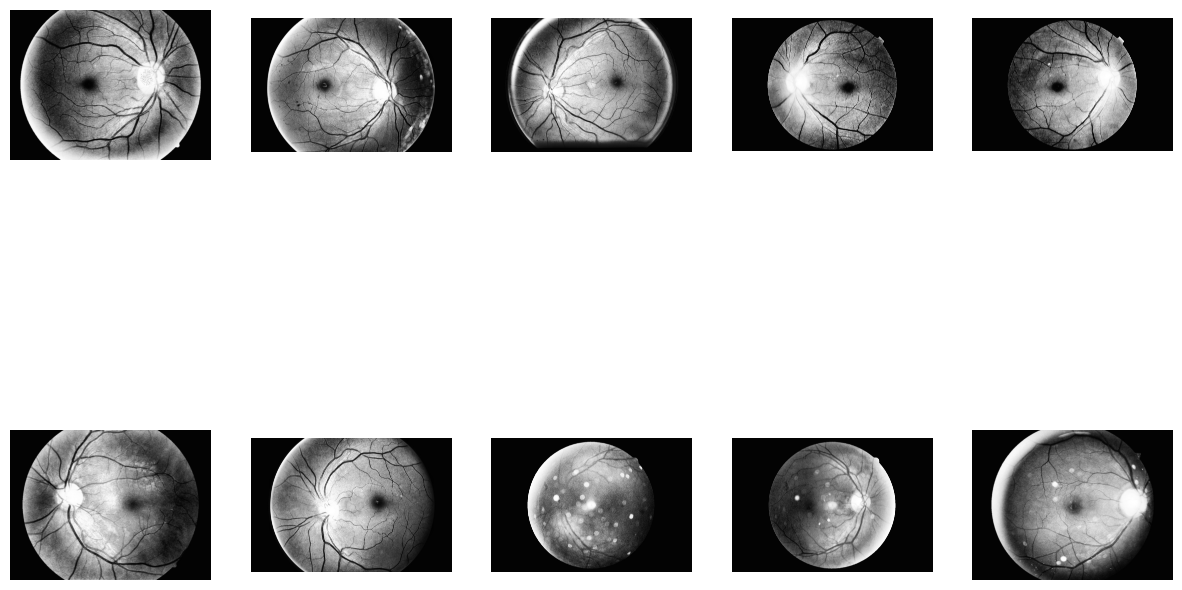

In [5]:
train_image_files = []
for subdir in os.listdir(train_dir):
    subdir_path = os.path.join(train_dir, subdir)
    if os.path.isdir(subdir_path):
        train_image_files.extend([os.path.join(subdir_path, file) for file in os.listdir(subdir_path) if file.endswith(('.png', '.jpg', '.jpeg'))])

# Load the first 10 images
images = [cv2.imread(file) for file in train_image_files[:10] if cv2.imread(file) is not None]

# Function to display images in a grid
def show_images(images, cols=5, rows=2):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            img_rgb = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display
            ax.imshow(img_rgb)
            ax.axis('off')  # Hide axes
    plt.show()

# Show the loaded images
show_images(images)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


TARGET_SIZE = (224, 224)
BATCH_SIZE = 4


train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,       
    rotation_range=20,       
    width_shift_range=0.2,   
    height_shift_range=0.2,  
    shear_range=0.2,        
    zoom_range=0.2,         
    horizontal_flip=True,    
    fill_mode='nearest'     
)

# Create a validation ImageDataGenerator
val_datagen = ImageDataGenerator(rescale=1.0 / 255)  # Normalize the images for validation

# Create a test ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1.0 / 255)  # Normalize the images for testing

# Create generators for training, validation, and test datasets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Categorical labels
    shuffle=True               
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Categorical labels
    shuffle=False               
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Categorical labels
    shuffle=False               
)


Found 10656 images belonging to 5 classes.
Found 1770 images belonging to 5 classes.
Found 4422 images belonging to 5 classes.


In [7]:
batch_x, batch_y = next(iter(train_generator))
print("Input shape:", batch_x.shape)
print("Label shape:", batch_y.shape)


Input shape: (4, 224, 224, 3)
Label shape: (4, 5)


In [9]:
import numpy as np

class_counts = {}
total_batches = len(train_generator)

for _ in range(total_batches):
    images, labels = next(train_generator)
    class_indices = tf.argmax(labels, axis=1).numpy()
    unique, counts = np.unique(class_indices, return_counts=True)
    for class_index, count in zip(unique, counts):
        if class_index in class_counts:
            class_counts[class_index] += count
        else:
            class_counts[class_index] = count


In [11]:
class_counts = {int(k): int(v) for k, v in class_counts.items()}
print(class_counts)

{0: 3988, 2: 3841, 1: 1749, 3: 573, 4: 505}


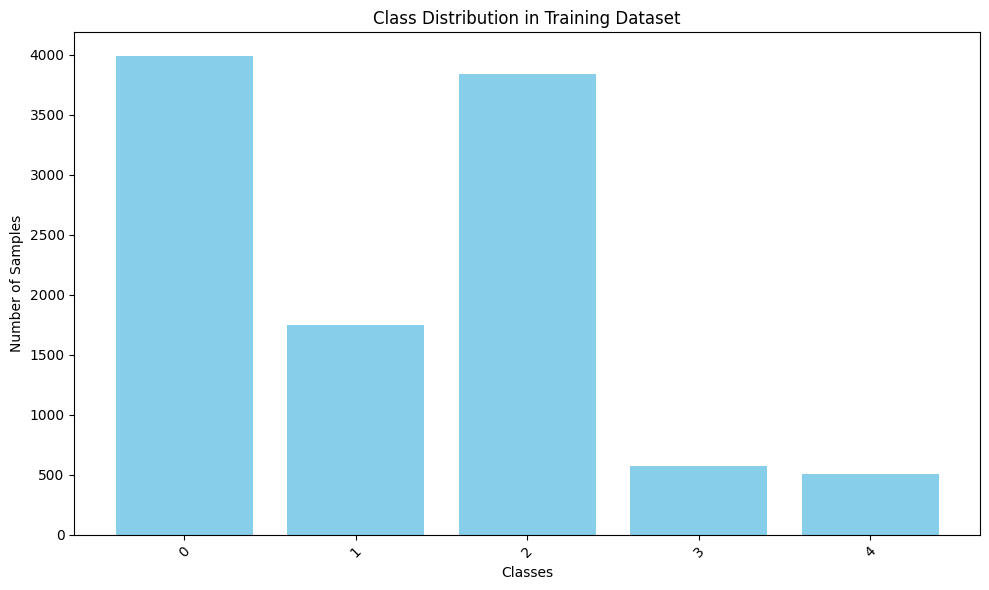

In [12]:
import matplotlib.pyplot as plt

def plot_class_distribution(class_counts):
    # Extract class names and counts
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution in Training Dataset')
    plt.xticks(rotation=45)  # Rotate class labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
    plt.show()

# Call the function with your class counts dictionary
plot_class_distribution(class_counts)


In [13]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


# Extract unique class labels and sample counts for each class
class_labels = np.array(list(class_counts.keys()))
samples_per_class = np.array(list(class_counts.values()))

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=np.repeat(class_labels, samples_per_class))

# Convert class weights to dictionary format
class_weight_dict = dict(zip(class_labels, class_weights))
print("Class Weights:", class_weight_dict)


Class Weights: {np.int64(0): np.float64(0.5344032096288867), np.int64(2): np.float64(0.5548555063785473), np.int64(1): np.float64(1.21852487135506), np.int64(3): np.float64(3.7193717277486913), np.int64(4): np.float64(4.22019801980198)}


In [15]:
class_weight_dict = {int(k): float(v) for k, v in class_weight_dict.items()}

# Output the class weights
print(class_weight_dict)

{0: 0.5344032096288867, 2: 0.5548555063785473, 1: 1.21852487135506, 3: 3.7193717277486913, 4: 4.22019801980198}


In [16]:
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, GlobalAveragePooling2D

base_model =  EfficientNetB5(include_top=False, weights='imagenet', input_shape=(224,224,3))
base_model.trainable = True


2024-10-29 23:37:06.818914: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


In [17]:
print(f"NUmber of layers in the model: {len(base_model.layers)}")

NUmber of layers in the model: 577


In [18]:
for layer in base_model.layers[:-100]:  # Freeze all layers except the last 200
    layer.trainable = False


In [19]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# model.summary()


In [20]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ cast[0][0]        │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,296 │ stem_conv_pad[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        192 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 48)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 48)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 12)  │        588 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 48)  │        624 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati

 Total params: 29,073,148 (110.91 MB)

 Trainable params: 16,515,617 (63.00 MB)

 Non-trainable params: 12,557,531 (47.90 MB)

In [21]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [22]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Precision, Recall

model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(),
        Recall(),
        AUC(multi_label=False, name='auc')
    ]
)

In [34]:
import tensorflow as tf
import matplotlib.pyplot as plt
from typing import Optional

class SimpleMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, every_n_epochs: int = 10, save_plots: bool = False, plot_path: str = 'accuracy_loss_plot.png'):
        super().__init__()
        self.every_n_epochs = every_n_epochs
        self.save_plots = save_plots
        self.plot_path = plot_path
        self.history = {
            'epochs': [],
            'train_accuracy': [],
            'val_accuracy': [],
            'train_loss': [],
            'val_loss': []
        }

    def on_epoch_end(self, epoch: int, logs: Optional[dict] = None) -> None:
        """Store accuracy and loss at the end of each epoch."""
        if logs is None:
            logs = {}
            
        # Append accuracy and loss to history
        self.history['epochs'].append(epoch + 1)
        self.history['train_accuracy'].append(logs.get('accuracy', 0))
        self.history['val_accuracy'].append(logs.get('val_accuracy', 0))
        self.history['train_loss'].append(logs.get('loss', 0))
        self.history['val_loss'].append(logs.get('val_loss', 0))
        
        # Log the results for this epoch
        tf.print(f'Epoch {epoch + 1}: Train Accuracy: {logs.get("accuracy", 0):.4f}, Val Accuracy: {logs.get("val_accuracy", 0):.4f}, '
                 f'Train Loss: {logs.get("loss", 0):.4f}, Val Loss: {logs.get("val_loss", 0):.4f}')
        
        # Plot the metrics every n epochs or at the last epoch
        if (epoch + 1) % self.every_n_epochs == 0 or epoch == self.params['epochs'] - 1:
            self.plot_metrics()

    def plot_metrics(self) -> None:
        """Plot accuracy and loss over epochs."""
        try:
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))

            # Plot accuracy
            axes[0].plot(self.history['epochs'], self.history['train_accuracy'], label='Train Accuracy', marker='o')
            axes[0].plot(self.history['epochs'], self.history['val_accuracy'], label='Val Accuracy', marker='o')
            axes[0].set_title('Accuracy over Epochs')
            axes[0].set_xlabel('Epochs')
            axes[0].set_ylabel('Accuracy')
            axes[0].legend()
            axes[0].grid(True)

            # Plot loss
            axes[1].plot(self.history['epochs'], self.history['train_loss'], label='Train Loss', marker='o')
            axes[1].plot(self.history['epochs'], self.history['val_loss'], label='Val Loss', marker='o')
            axes[1].set_title('Loss over Epochs')
            axes[1].set_xlabel('Epochs')
            axes[1].set_ylabel('Loss')
            axes[1].legend()
            axes[1].grid(True)

            plt.tight_layout()
            
            # Save or show the plot
            if self.save_plots:
                plt.savefig(self.plot_path)
                plt.close()
            else:
                plt.show()
                
        except Exception as e:
            tf.print(f"Error plotting metrics: {str(e)}")


In [25]:
num_train_samples = train_generator.n
num_val_samples = val_generator.n

print(f"num_train_samples: {num_train_samples}")
print(f"num_val_samples: {num_val_samples}")


num_train_samples: 10656
num_val_samples: 1770


Epoch 1/5


I0000 00:00:1730225333.653045  149350 service.cc:148] XLA service 0x7e359c004470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730225333.653232  149350 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-10-29 23:38:54.726758: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1730225338.089874  149350 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/2664 ━━━━━━━━━━━━━━━━━━━━ 32:10:13 43s/step - accuracy: 0.0000e+00 - auc: 0.5781 - loss: 2.2902 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1730225365.782197  149350 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2664/2664 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.2989 - auc: 0.6224 - loss: 1.8917 - precision: 0.2938 - recall: 0.1402

2024-10-29 23:45:02.157994: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5470', 8 bytes spill stores, 8 bytes spill loads

2024-10-29 23:45:02.158070: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5483', 12 bytes spill stores, 12 bytes spill loads

2024-10-29 23:45:02.276567: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5483', 4 bytes spill stores, 4 bytes spill loads




Epoch 1: val_loss improved from inf to 1.22619, saving model to EfficientNet_model.keras
Epoch 1: Train Accuracy: 0.3349, Val Accuracy: 0.5769, Train Loss: 1.6156, Val Loss: 1.2262
2664/2664 ━━━━━━━━━━━━━━━━━━━━ 430s 145ms/step - accuracy: 0.2989 - auc: 0.6224 - loss: 1.8916 - precision: 0.2938 - recall: 0.1402 - val_accuracy: 0.5769 - val_auc: 0.8247 - val_loss: 1.2262 - val_precision: 0.5978 - val_recall: 0.0311 - learning_rate: 0.0010
Epoch 2/5


2024-10-29 23:45:52.285054: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-10-29 23:45:52.287150: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17718985416601864024
2024-10-29 23:45:54.227556: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5470', 8 bytes spill stores, 8 bytes spill loads

2024-10-29 23:45:54.351027: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5483', 8 bytes spill stores, 8 bytes spill loads




Epoch 2: val_loss did not improve from 1.22619
Epoch 2: Train Accuracy: 0.0000, Val Accuracy: 0.0000, Train Loss: 0.0000, Val Loss: 3.2630


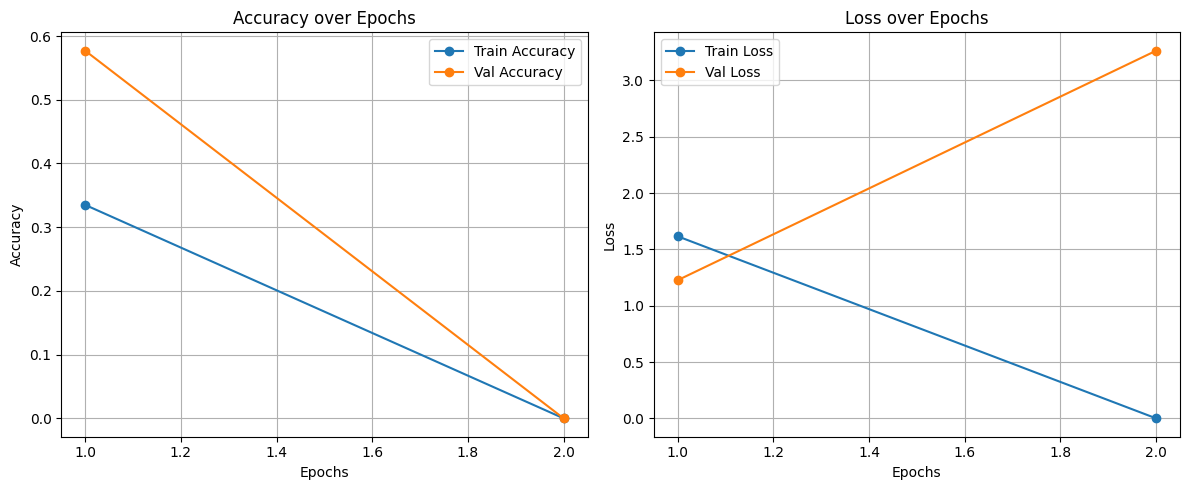

2664/2664 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_auc: 0.0938 - val_loss: 3.2630 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/5
2664/2664 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.3655 - auc: 0.7314 - loss: 1.3887 - precision: 0.3643 - recall: 0.0412
Epoch 3: val_loss did not improve from 1.22619
Epoch 3: Train Accuracy: 0.3666, Val Accuracy: 0.5124, Train Loss: 1.3838, Val Loss: 2.2970
2664/2664 ━━━━━━━━━━━━━━━━━━━━ 360s 135ms/step - accuracy: 0.3655 - auc: 0.7314 - loss: 1.3887 - precision: 0.3643 - recall: 0.0412 - val_accuracy: 0.5124 - val_auc: 0.7468 - val_loss: 2.2970 - val_precision: 0.0321 - val_recall: 0.0028 - learning_rate: 0.0010
Epoch 4/5

Epoch 4: val_loss did not improve from 1.22619

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 4: Train Accuracy: 0.0000, V

2024-10-29 23:52:03.206168: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-10-29 23:52:03.206218: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17718985416601864024


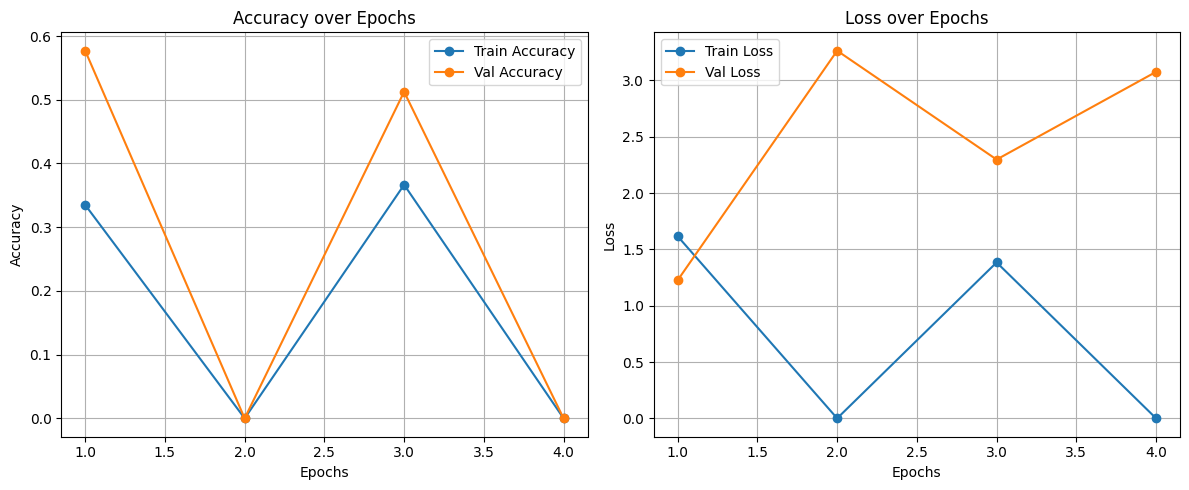

2664/2664 ━━━━━━━━━━━━━━━━━━━━ 0s 86us/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 3.0754 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/5
2664/2664 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.3602 - auc: 0.7311 - loss: 1.3720 - precision: 0.3261 - recall: 0.0086
Epoch 5: val_loss did not improve from 1.22619
Epoch 5: Train Accuracy: 0.3666, Val Accuracy: 0.5390, Train Loss: 1.3605, Val Loss: 1.8253


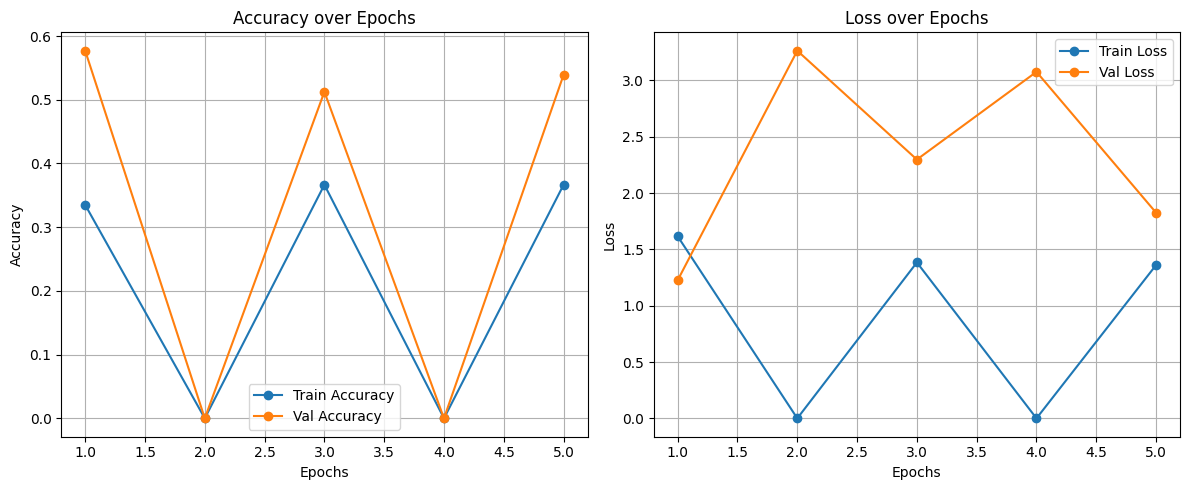

2664/2664 ━━━━━━━━━━━━━━━━━━━━ 360s 135ms/step - accuracy: 0.3602 - auc: 0.7311 - loss: 1.3720 - precision: 0.3261 - recall: 0.0086 - val_accuracy: 0.5390 - val_auc: 0.7743 - val_loss: 1.8253 - val_precision: 0.0849 - val_recall: 0.0051 - learning_rate: 2.0000e-04
Restoring model weights from the end of the best epoch: 1.


In [27]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('EfficientNet_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
callback = SimpleMetricsCallback(every_n_epochs=2)


history = model.fit(
    train_generator,
    steps_per_epoch= num_train_samples//BATCH_SIZE,
    validation_data=val_generator,
    validation_steps= num_val_samples//BATCH_SIZE,
    epochs=5,
    # class_weight=class_weight_dict,
    callbacks=[early_stopping, model_checkpoint, reduce_lr, callback]
)

In [32]:
from tensorflow.keras.callbacks import TensorBoard
log_dir = "logs/fit/EfficientNetB5"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


Epoch 14/50
2664/2664 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.3621 - auc: 0.7361 - loss: 1.3484 - precision: 0.4484 - recall: 4.0160e-04
Epoch 14: val_loss improved from inf to 1.38608, saving model to EfficientNet_model.keras
Epoch 14: Train Accuracy: 0.3668, Val Accuracy: 0.4666, Train Loss: 1.3468, Val Loss: 1.3861
2664/2664 ━━━━━━━━━━━━━━━━━━━━ 417s 140ms/step - accuracy: 0.3621 - auc: 0.7361 - loss: 1.3484 - precision: 0.4484 - recall: 4.0176e-04 - val_accuracy: 0.4666 - val_auc: 0.7660 - val_loss: 1.3861 - val_precision: 0.2281 - val_recall: 0.0339 - learning_rate: 2.0000e-04
Epoch 15/50


2024-10-30 00:55:39.040475: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11669139430153830021
2024-10-30 00:55:39.040571: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17718985416601864024



Epoch 15: val_loss did not improve from 1.38608
Epoch 15: Train Accuracy: 0.0000, Val Accuracy: 0.0000, Train Loss: 0.0000, Val Loss: 2.9952


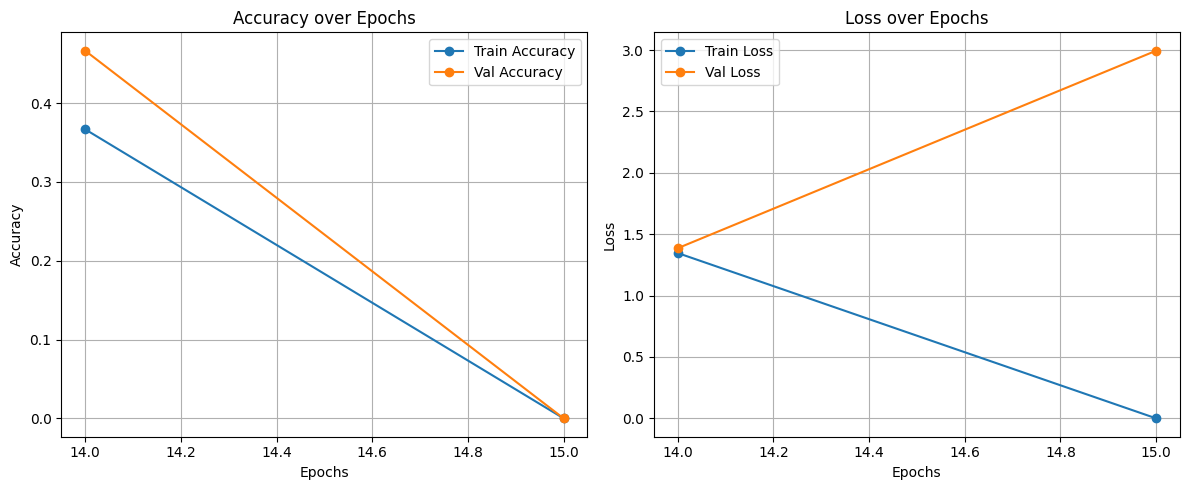

2664/2664 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_auc: 0.0625 - val_loss: 2.9952 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 2.0000e-04
Epoch 16/50
2664/2664 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.3635 - auc: 0.7362 - loss: 1.3442 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 16: val_loss improved from 1.38608 to 1.33538, saving model to EfficientNet_model.keras
Epoch 16: Train Accuracy: 0.3598, Val Accuracy: 0.5300, Train Loss: 1.3475, Val Loss: 1.3354
2664/2664 ━━━━━━━━━━━━━━━━━━━━ 347s 130ms/step - accuracy: 0.3635 - auc: 0.7362 - loss: 1.3442 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5300 - val_auc: 0.7942 - val_loss: 1.3354 - val_precision: 0.4032 - val_recall: 0.0566 - learning_rate: 2.0000e-04
Epoch 17/50

Epoch 17: val_loss did not improve from 1.33538
Epoch 17: Train Accuracy: 0.0000, Va

2024-10-30 01:01:35.135509: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11669139430153830021
2024-10-30 01:01:35.135572: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17718985416601864024


2664/2664 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_auc: 0.0312 - val_loss: 3.3734 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 2.0000e-04
Epoch 18/50
2664/2664 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.3732 - auc: 0.7360 - loss: 1.3494 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 18: val_loss improved from 1.33538 to 1.23341, saving model to EfficientNet_model.keras
Epoch 18: Train Accuracy: 0.3747, Val Accuracy: 0.3298, Train Loss: 1.3436, Val Loss: 1.2334
2664/2664 ━━━━━━━━━━━━━━━━━━━━ 357s 134ms/step - accuracy: 0.3732 - auc: 0.7360 - loss: 1.3494 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3298 - val_auc: 0.7601 - val_loss: 1.2334 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 2.0000e-04
Epoch 19/50

Epoch 19: val_loss did not improve from 1.23341
Epoch 19: Train Accuracy: 0.

2024-10-30 01:07:35.536179: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11669139430153830021
2024-10-30 01:07:35.536250: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17718985416601864024


2664/2664 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 3.1812 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 2.0000e-04
Epoch 20/50
2664/2664 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.3692 - auc: 0.7392 - loss: 1.3381 - precision: 0.2406 - recall: 1.4919e-04
Epoch 20: val_loss improved from 1.23341 to 1.20359, saving model to EfficientNet_model.keras


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/media/ritika/BAB4DC86B4DC4713/ICDCIT/Diabetic Retinopathy/Diabetic-Retinopathy/EfficientNet_model.keras')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('EfficientNet_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
custom_metrics_callback = SimpleMetricsCallback(every_n_epochs=5)

model.optimizer.lr = 0.00001

history = model.fit(
    train_generator,
    steps_per_epoch=num_train_samples//BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=num_val_samples//BATCH_SIZE,
    epochs=50,            
    initial_epoch=13,     
    callbacks=[early_stopping, model_checkpoint, reduce_lr,custom_metrics_callback,tensorboard_callback]
)
